In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tymochka","key":"e186de82e11d46b52689168228dda72f"}'}

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:12<00:00, 230MB/s]
100% 5.20G/5.20G [01:12<00:00, 77.3MB/s]


In [6]:
!unzip -q skin-cancer-mnist-ham10000.zip -d ham10000

In [7]:
import os
import pandas as pd

df_skin = pd.read_csv("ham10000/HAM10000_metadata.csv")
df_skin.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
image_dir_1 = 'ham10000/ham10000_images_part_1'
image_dir_2 = 'ham10000/ham10000_images_part_2'

all_image_files = {}
for fname in os.listdir(image_dir_1):
    all_image_files[fname] = os.path.join(image_dir_1, fname)
for fname in os.listdir(image_dir_2):
    all_image_files[fname] = os.path.join(image_dir_2, fname)

# Додамо шлях до DataFrame
df_skin['image_path'] = df_skin['image_id'].map(lambda x: all_image_files.get(f"{x}.jpg"))

In [9]:
class_names = sorted(df_skin['dx'].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
df_skin['label'] = df_skin['dx'].map(class_to_idx)

print("Мапінг класів:", class_to_idx)

Мапінг класів: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_skin,
    test_size=0.2,
    stratify=df_skin['label'],
    random_state=42
)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}")

Train: 8012, Validation: 2003


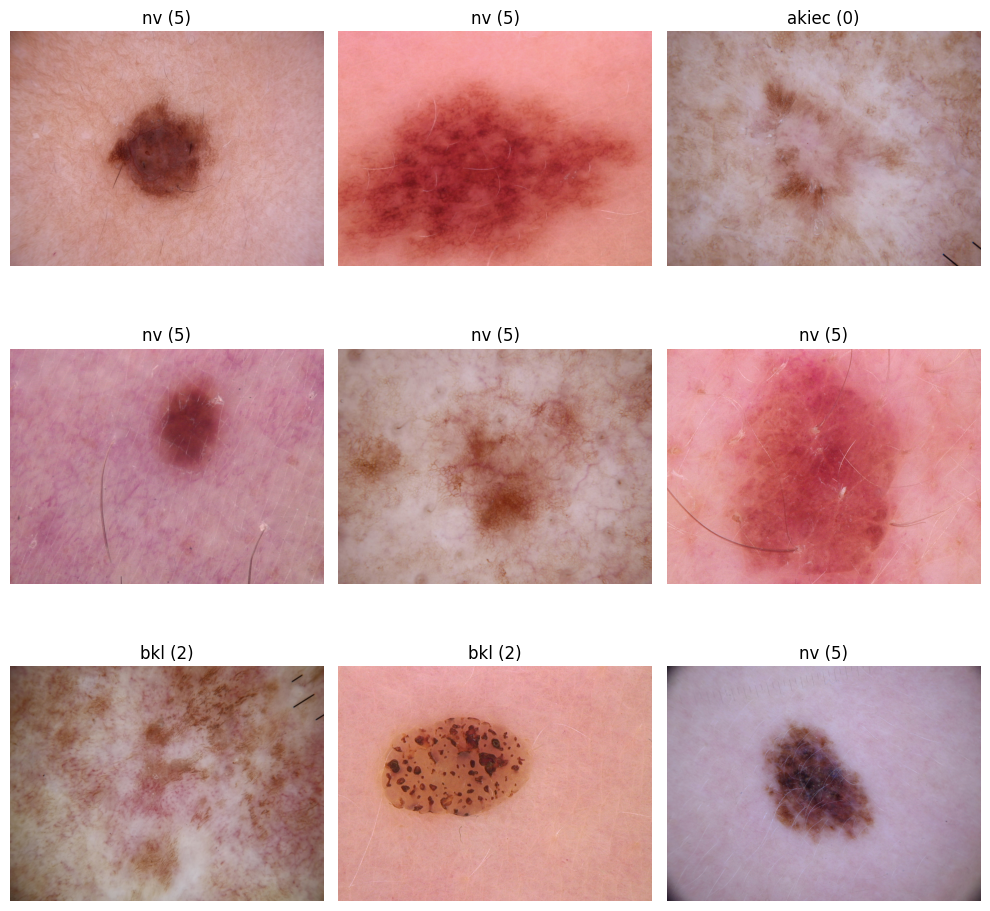

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    row = train_df.iloc[i]
    img = Image.open(row['image_path'])
    ax.imshow(img)
    ax.set_title(f"{row['dx']} ({row['label']})")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
!pip install -q transformers

In [13]:
checkpoint = 'microsoft/swin-tiny-patch4-window7-224'

In [14]:
from torch.utils.data import Dataset
from transformers import AutoImageProcessor
from PIL import Image

processor = AutoImageProcessor.from_pretrained(checkpoint)

class SkinDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')  # just in case
        label = row['label']
        inputs = self.processor(image, return_tensors="pt")
        return {
            "pixel_values": inputs['pixel_values'].squeeze(0),
            "label": label
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [15]:
from torch.utils.data import DataLoader

train_dataset = SkinDataset(train_df, processor)
val_dataset = SkinDataset(val_df, processor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [16]:
import torch
import torch.nn as nn
from transformers import AutoModel

class SwinClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SwinClassifier, self).__init__()
        self.backbone = AutoModel.from_pretrained(checkpoint)
        self.backbone.config.return_dict = False  # щоб поверталось як tuple
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        features = self.backbone(pixel_values)[0]  # беремо CLS token
        cls_token = features[:, 0, :]  # (batch_size, hidden_dim)
        logits = self.classifier(cls_token)
        return logits


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinClassifier(num_classes=len(class_to_idx))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [18]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import time

def evaluate_model(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["pixel_values"].to(device)
            targets = batch["label"].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return f1_score(labels, preds, average='macro')

epochs = 5
for epoch in range(epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in train_bar:
        inputs = batch["pixel_values"].to(device)
        targets = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    val_f1 = evaluate_model(model, val_loader)

    epoch_time = time.time() - start_time
    print(f"\n✅ Epoch {epoch+1} completed in {epoch_time:.1f} sec | Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f}\n")


Epoch 1/5: 100%|██████████| 501/501 [03:23<00:00,  2.46it/s, loss=0.839]



✅ Epoch 1 completed in 239.3 sec | Loss: 0.7992 | Val F1: 0.5200



Epoch 2/5: 100%|██████████| 501/501 [03:19<00:00,  2.51it/s, loss=0.581]



✅ Epoch 2 completed in 233.2 sec | Loss: 0.4872 | Val F1: 0.6421



Epoch 3/5: 100%|██████████| 501/501 [03:16<00:00,  2.55it/s, loss=0.464]



✅ Epoch 3 completed in 229.9 sec | Loss: 0.3380 | Val F1: 0.7994



Epoch 4/5: 100%|██████████| 501/501 [03:16<00:00,  2.55it/s, loss=0.37]



✅ Epoch 4 completed in 229.3 sec | Loss: 0.2244 | Val F1: 0.7743



Epoch 5/5: 100%|██████████| 501/501 [03:16<00:00,  2.55it/s, loss=0.0755]



✅ Epoch 5 completed in 230.0 sec | Loss: 0.1415 | Val F1: 0.7847



In [19]:
final_f1 = evaluate_model(model, val_loader)
print(f"🎯 Final F1-score (val): {final_f1:.4f}")

🎯 Final F1-score (val): 0.7847


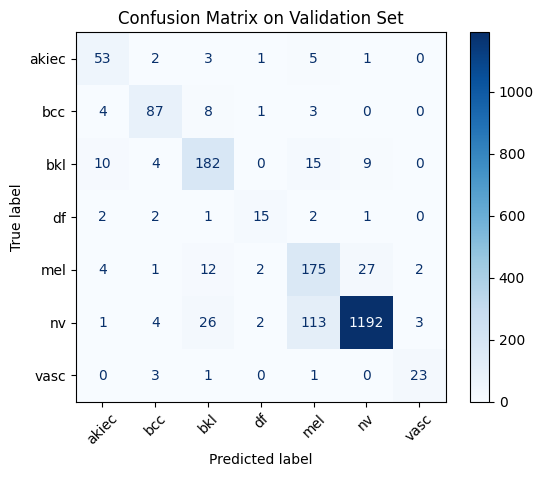

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
preds, labels = [], []

with torch.no_grad():
    for batch in val_loader:
        inputs = batch["pixel_values"].to(device)
        targets = batch["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        labels.extend(targets.cpu().numpy())

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix on Validation Set")
plt.show()